<a href="https://colab.research.google.com/github/LucianoPer/NPL/blob/main/3_RNN_Recurrent_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En redes recurrentes la estructura neuronal es diferente a las redes tradicionales. 

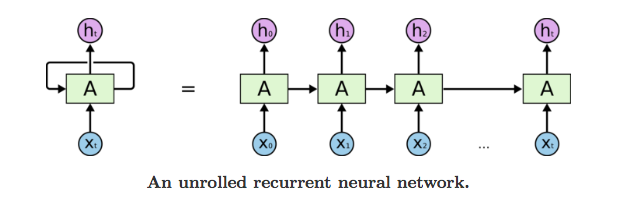

**RNN-Bidireccional**
Consiste en relacionar las neuronas en dos direcciones, de tal forma que podemos tener en cuenta en el contexto la palabra anterior y la palabra futura. Es decir, miramos el texto en ambos sentidos.  

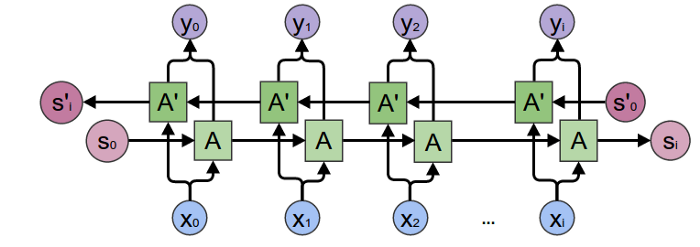

Dos problemas que aparecen al complejizar las redes:
- Los gradientes explotan : (solucion) Se limita el valor maximo 
- Los grandientes desaparecen : (solucion) Long-short term memory 

Redes **Seq2Seq** :

Consiste en una red que combina RNN con Encoder/Decoder. La entrada a la red es una secuencia y la salida tambien es otra secuencia. Se utilizan por lo general en: Traducciones, Chatbot.

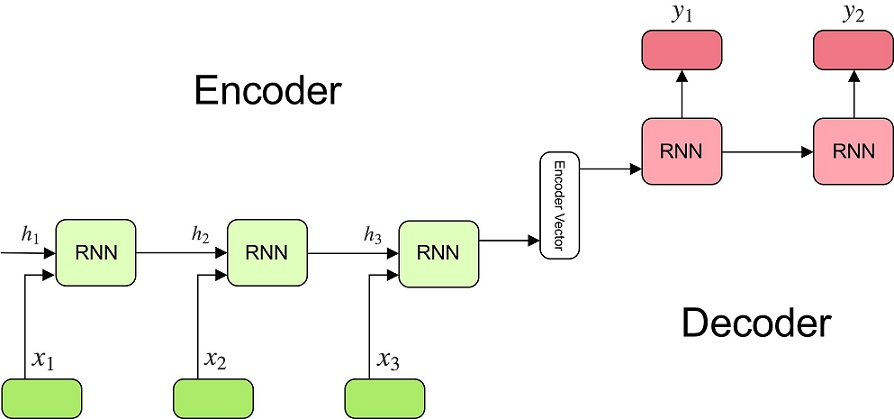

Mejoras de la salida del encoder (contexto):

- **Atention**: Tiene en cuenta las palabras mas relevantes
- **Transformers**: Otra tecnica para tener en cuenta la relevancia de las palabras

La salida del Encoder puede ser utilizada para generar un clasificador , y por lo tanto generar un clasificador sentimientos o intenciones. Solo se deben agregar las ultimas capas del clasificador.  

### Implementacion de Redes LSTM

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
import nltk
from nltk.tokenize import word_tokenize

import re
import numpy as np
import random
import io
import pickle
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/NLP/songs_dataset/prince.txt', sep='/n', header=None)

data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,0
0,All of this and more is for you
1,"With love, sincerity and deepest care"
2,My life with you I share
3,"Ever since I met you, baby"
4,I've been wantin' to lay you down


In [ ]:
# Se hace una secuencia que va desfasando las frases una a una

train_len = 4 # largo de la secuencia, incluye seq input + word output
text_sequences = []

tokens=text_to_word_sequence(data.loc[0,0]) 
# código para hacer el desfazaje de las palabras
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

text_sequences

[['all', 'of', 'this', 'and'],
 ['of', 'this', 'and', 'more'],
 ['this', 'and', 'more', 'is'],
 ['and', 'more', 'is', 'for']]

In [ ]:
# tokenizamos el texto para utilizarlo como entrada de nuestra red LSTM

tokenizer = Tokenizer()

tokenizer.fit_on_texts( text_sequences )

sequences = tokenizer.texts_to_sequences( text_sequences )

sequences

[[6, 4, 2, 1], [4, 2, 1, 3], [2, 1, 3, 5], [1, 3, 5, 7]]

In [ ]:
print('Cantidad de documentos ', tokenizer.document_count)
print('Cantidad de palabras ',tokenizer.word_counts)
print('Indice de palabras ', tokenizer.word_index)

Cantidad de documentos  4
Cantidad de palabras  OrderedDict([('all', 1), ('of', 2), ('this', 3), ('and', 4), ('more', 3), ('is', 2), ('for', 1)])
Indice de palabras  {'and': 1, 'this': 2, 'more': 3, 'of': 4, 'is': 5, 'all': 6, 'for': 7}


In [ ]:
# Debemos tokenizar todas las palabras, pero antes concantenamos las lineas del texto sepado por saltos de linea en un solo texto

texto = data.apply( lambda row: ' '.join( row.values.astype(str)), axis=0)[0]

texto

'All of this and more is for you With love, sincerity and deepest care My life with you I share Ever since I met you, baby I\'ve been wantin\' to lay you down But it\'s so hard to get you Baby, when you never come around Every day that you keep it away It only makes me want it more Ooh baby, just say the word And I\'ll be at your door What more do I have to say? I really wanna play in your river Fallin\', fallin\', fallin\' in love I\'m fallin\', baby, deeper every day (In love) You\'re breakin\' my heart and takin\' me away (In love) I\'m fallin\' baby, girl, what can I do? I just can\'t be without you Ever since I met you, baby There\'s been somethin\' inside of me That keeps me wantin\' you Baby, won\'t you set me free? Take off these chains, girl And I\'ll take off yours There\'s no one in the world, baby That I wanna love more What else do I have to say? I really wanna play in your river Fallin\', fallin\', fallin\' in love I\'m fallin\' baby, deeper every day (In love) You\'re br

In [ ]:
tokens = text_to_word_sequence( texto )

tokens

['all',
 'of',
 'this',
 'and',
 'more',
 'is',
 'for',
 'you',
 'with',
 'love',
 'sincerity',
 'and',
 'deepest',
 'care',
 'my',
 'life',
 'with',
 'you',
 'i',
 'share',
 'ever',
 'since',
 'i',
 'met',
 'you',
 'baby',
 "i've",
 'been',
 "wantin'",
 'to',
 'lay',
 'you',
 'down',
 'but',
 "it's",
 'so',
 'hard',
 'to',
 'get',
 'you',
 'baby',
 'when',
 'you',
 'never',
 'come',
 'around',
 'every',
 'day',
 'that',
 'you',
 'keep',
 'it',
 'away',
 'it',
 'only',
 'makes',
 'me',
 'want',
 'it',
 'more',
 'ooh',
 'baby',
 'just',
 'say',
 'the',
 'word',
 'and',
 "i'll",
 'be',
 'at',
 'your',
 'door',
 'what',
 'more',
 'do',
 'i',
 'have',
 'to',
 'say',
 'i',
 'really',
 'wanna',
 'play',
 'in',
 'your',
 'river',
 "fallin'",
 "fallin'",
 "fallin'",
 'in',
 'love',
 "i'm",
 "fallin'",
 'baby',
 'deeper',
 'every',
 'day',
 'in',
 'love',
 "you're",
 "breakin'",
 'my',
 'heart',
 'and',
 "takin'",
 'me',
 'away',
 'in',
 'love',
 "i'm",
 "fallin'",
 'baby',
 'girl',
 'what',
 '

In [ ]:
# Se hace una secuencia que va desfasando las frases una a una

train_len = 4 # largo de la secuencia, incluye seq input + word output
text_sequences = []

# código para hacer el desfazaje de las palabras
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

text_sequences

[['all', 'of', 'this', 'and'],
 ['of', 'this', 'and', 'more'],
 ['this', 'and', 'more', 'is'],
 ['and', 'more', 'is', 'for'],
 ['more', 'is', 'for', 'you'],
 ['is', 'for', 'you', 'with'],
 ['for', 'you', 'with', 'love'],
 ['you', 'with', 'love', 'sincerity'],
 ['with', 'love', 'sincerity', 'and'],
 ['love', 'sincerity', 'and', 'deepest'],
 ['sincerity', 'and', 'deepest', 'care'],
 ['and', 'deepest', 'care', 'my'],
 ['deepest', 'care', 'my', 'life'],
 ['care', 'my', 'life', 'with'],
 ['my', 'life', 'with', 'you'],
 ['life', 'with', 'you', 'i'],
 ['with', 'you', 'i', 'share'],
 ['you', 'i', 'share', 'ever'],
 ['i', 'share', 'ever', 'since'],
 ['share', 'ever', 'since', 'i'],
 ['ever', 'since', 'i', 'met'],
 ['since', 'i', 'met', 'you'],
 ['i', 'met', 'you', 'baby'],
 ['met', 'you', 'baby', "i've"],
 ['you', 'baby', "i've", 'been'],
 ['baby', "i've", 'been', "wantin'"],
 ["i've", 'been', "wantin'", 'to'],
 ['been', "wantin'", 'to', 'lay'],
 ["wantin'", 'to', 'lay', 'you'],
 ['to', 'lay', 

In [ ]:
tokenizer.fit_on_texts(text_sequences) 

sequences = tokenizer.texts_to_sequences(text_sequences) # entran palabras -> salen números

sequences

[[15, 23, 34, 6],
 [23, 34, 6, 97],
 [34, 6, 97, 22],
 [6, 97, 22, 119],
 [97, 22, 119, 17],
 [22, 119, 17, 36],
 [119, 17, 36, 13],
 [17, 36, 13, 2260],
 [36, 13, 2260, 6],
 [13, 2260, 6, 2261],
 [2260, 6, 2261, 195],
 [6, 2261, 195, 12],
 [2261, 195, 12, 94],
 [195, 12, 94, 36],
 [12, 94, 36, 17],
 [94, 36, 17, 3],
 [36, 17, 3, 1394],
 [17, 3, 1394, 99],
 [3, 1394, 99, 627],
 [1394, 99, 627, 3],
 [99, 627, 3, 885],
 [627, 3, 885, 17],
 [3, 885, 17, 20],
 [885, 17, 20, 120],
 [17, 20, 120, 161],
 [20, 120, 161, 1395],
 [120, 161, 1395, 25],
 [161, 1395, 25, 311],
 [1395, 25, 311, 17],
 [25, 311, 17, 53],
 [311, 17, 53, 50],
 [17, 53, 50, 47],
 [53, 50, 47, 28],
 [50, 47, 28, 250],
 [47, 28, 250, 25],
 [28, 250, 25, 41],
 [250, 25, 41, 17],
 [25, 41, 17, 20],
 [41, 17, 20, 39],
 [17, 20, 39, 17],
 [20, 39, 17, 79],
 [39, 17, 79, 31],
 [17, 79, 31, 132],
 [79, 31, 132, 95],
 [31, 132, 95, 117],
 [132, 95, 117, 11],
 [95, 117, 11, 17],
 [117, 11, 17, 207],
 [11, 17, 207, 8],
 [17, 207, 8

In [ ]:
# Pasamos a np array y separamos la ultima columna

array_sequences=np.array(sequences)

x_data = array_sequences[:,:-1] # Seleccionamos todas las columnas menos la ultima
y_data = array_sequences[:,-1] # Seleccionamos la ultima columna

In [ ]:
print(x_data.shape)
print(y_data.shape)

(63147, 3)
(63147,)


In [ ]:
tokenizer.index_word

{1: 'the',
 2: 'u',
 3: 'i',
 4: 'a',
 5: '2',
 6: 'and',
 7: 'me',
 8: 'it',
 9: 'in',
 10: 'your',
 11: 'that',
 12: 'my',
 13: 'love',
 14: 'do',
 15: 'all',
 16: 'we',
 17: 'you',
 18: 'on',
 19: 'yeah',
 20: 'baby',
 21: 'be',
 22: 'is',
 23: 'of',
 24: "don't",
 25: 'to',
 26: '4',
 27: "i'm",
 28: 'so',
 29: 'if',
 30: 'go',
 31: 'come',
 32: 'just',
 33: 'oh',
 34: 'this',
 35: 'what',
 36: 'with',
 37: 'got',
 38: 'no',
 39: 'when',
 40: 'can',
 41: 'get',
 42: 'like',
 43: 'say',
 44: 'will',
 45: 'wanna',
 46: 'know',
 47: "it's",
 48: 'up',
 49: 'time',
 50: 'but',
 51: 'want',
 52: 'gonna',
 53: 'down',
 54: 'la',
 55: 'now',
 56: 'are',
 57: "can't",
 58: 'was',
 59: "i'll",
 60: 'see',
 61: 'they',
 62: 'there',
 63: 'how',
 64: 'tell',
 65: "that's",
 66: 'have',
 67: 'one',
 68: 'she',
 69: 'night',
 70: 'would',
 71: 'not',
 72: 'right',
 73: 'make',
 74: 'girl',
 75: 'let',
 76: 'take',
 77: 'everybody',
 78: 'he',
 79: 'never',
 80: 'ooh',
 81: 'could',
 82: "let's"

In [ ]:
# El indice del tokenizer arranca en 1, para evitar que se produzca un error al pasarlo  a to_catergorical restamos 1
y_data = y_data - 1

vocab_size = len(tokenizer.word_counts)

# Pasamos a OHE los valores de entrada
y_data_OHE = to_categorical(y_data, num_classes=vocab_size) 

y_data_OHE.shape

(63147, 4080)

In [ ]:
# Creamos el modelo RNN

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout



In [ ]:
vocab_size = len(tokenizer.word_counts)

input_seq_len = x_data.shape[1] # largo de la secuencia de entrada

In [ ]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size+1, output_dim=3, input_length=input_seq_len))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
# La utlima capa no utiliza return_sequences
model.add(LSTM(64))
model.add(Dense(32,activation='relu'))
model.add(Dense(vocab_size, activation='softmax')) 

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 3, 3)              12243     
_________________________________________________________________
lstm_4 (LSTM)                (None, 3, 64)             17408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 4080)              134640    
Total params: 199,395
Trainable params: 199,395
Non-trainable params: 0
________________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("RNN_prince/model_{epoch}.h5")]

In [ ]:
history = model.fit(x_data, y_data_OHE, epochs=10, validation_split=0.2, callbacks=callbacks)

Epoch 1/10
1579/1579 [==============================] - 22s 12ms/step - loss: 6.6617 - accuracy: 0.0303 - val_loss: 6.6800 - val_accuracy: 0.0429
Epoch 2/10
1579/1579 [==============================] - 19s 12ms/step - loss: 6.1492 - accuracy: 0.0318 - val_loss: 6.7728 - val_accuracy: 0.0425
Epoch 3/10
1579/1579 [==============================] - 18s 12ms/step - loss: 6.0359 - accuracy: 0.0361 - val_loss: 6.8202 - val_accuracy: 0.0382
Epoch 4/10
1579/1579 [==============================] - 18s 12ms/step - loss: 5.8400 - accuracy: 0.0413 - val_loss: 6.8881 - val_accuracy: 0.0390
Epoch 5/10
1579/1579 [==============================] - 18s 11ms/step - loss: 5.6674 - accuracy: 0.0447 - val_loss: 6.9326 - val_accuracy: 0.0469
Epoch 6/10
1579/1579 [==============================] - 18s 11ms/step - loss: 5.5146 - accuracy: 0.0537 - val_loss: 7.0854 - val_accuracy: 0.0529
Epoch 7/10
1579/1579 [==============================] - 18s 11ms/step - loss: 5.3959 - accuracy: 0.0630 - val_loss: 7.3157 -

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_all(history):
  fig1 = go.Figure()
  fig1.add_trace(go.Scattergl(y=history.history['accuracy'], name='Train'))
  fig1.add_trace(go.Scattergl(y=history.history['val_accuracy'], name='Valid'))
  fig1.update_layout(height=300, width=400,xaxis_title='Epoch',yaxis_title='Accuracy')

  fig2 = go.Figure()
  fig2.add_trace(go.Scattergl(y=history.history['loss'], name='Train'))
  fig2.add_trace(go.Scattergl(y=history.history['val_loss'], name='Valid'))
  fig2.update_layout(height=300, width=400,xaxis_title='Epoch', yaxis_title='Loss')

  return [fig1,fig2]

In [ ]:
fig1,fig2=plot_all(history)
fig1.show()
fig2.show()

In [ ]:
# Generamos secuencias 

def generate_seq(model, tokenizer, max_length, seed_text, n_words):
	in_text = seed_text
	# generate a fixed number of words
	for _ in range(n_words):
		# Encodeamos
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		# Si tienen distinto largo
		encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
		yhat = model.predict_classes(encoded, verbose=0)
		# Vamos concatenando las predicciones
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# Agrego las palabras a la frase predicha
		in_text += ' ' + out_word
	return in_text

In [ ]:
input_text='I wanna be'

generate_seq(model, tokenizer, 3, input_text, 3)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



'I wanna be i with and'

### Probamos con otros datos

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/NLP/songs_dataset/bob-dylan.txt', sep='/n', header=None)

data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



,0
0,"“There must be some way out of here,” said the..."
1,"“There’s too much confusion, I can’t get no re..."
2,"Businessmen, they drink my wine, plowmen dig m..."
3,None of them along the line know what any of i...
4,"“No reason to get excited,” the thief, he kind..."


In [ ]:
texto = data.apply( lambda row: ' '.join( row.values.astype(str)), axis=0)[0]

texto

'“There must be some way out of here,” said the joker to the thief “There’s too much confusion, I can’t get no relief Businessmen, they drink my wine, plowmen dig my earth None of them along the line know what any of it is worth” “No reason to get excited,” the thief, he kindly spoke “There are many here among us who feel that life is but a joke But you and I, we’ve been through that, and this is not our fate So let us not talk falsely now, the hour is getting late” All along the watchtower, princes kept the view While all the women came and went, barefoot servants, too Outside in the distance a wildcat did growl Two riders were approaching, the wind began to howl Once upon a time you dressed so fine You threw the bums a dime in your prime, didn’t you? People’d call, say, “Beware doll, you’re bound to fall” You thought they were all kiddin’ you You used to laugh about Everybody that was hangin’ out Now you don’t talk so loud Now you don’t seem so proud About having to be scrounging for

In [ ]:
tokens = text_to_word_sequence( texto )

# Se hace una secuencia que va desfasando las frases una a una

train_len = 5 # largo de la secuencia, incluye seq input + word output
text_sequences = []

# código para hacer el desfazaje de las palabras
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

text_sequences

[['“there', 'must', 'be', 'some', 'way'],
 ['must', 'be', 'some', 'way', 'out'],
 ['be', 'some', 'way', 'out', 'of'],
 ['some', 'way', 'out', 'of', 'here'],
 ['way', 'out', 'of', 'here', '”'],
 ['out', 'of', 'here', '”', 'said'],
 ['of', 'here', '”', 'said', 'the'],
 ['here', '”', 'said', 'the', 'joker'],
 ['”', 'said', 'the', 'joker', 'to'],
 ['said', 'the', 'joker', 'to', 'the'],
 ['the', 'joker', 'to', 'the', 'thief'],
 ['joker', 'to', 'the', 'thief', '“there’s'],
 ['to', 'the', 'thief', '“there’s', 'too'],
 ['the', 'thief', '“there’s', 'too', 'much'],
 ['thief', '“there’s', 'too', 'much', 'confusion'],
 ['“there’s', 'too', 'much', 'confusion', 'i'],
 ['too', 'much', 'confusion', 'i', 'can’t'],
 ['much', 'confusion', 'i', 'can’t', 'get'],
 ['confusion', 'i', 'can’t', 'get', 'no'],
 ['i', 'can’t', 'get', 'no', 'relief'],
 ['can’t', 'get', 'no', 'relief', 'businessmen'],
 ['get', 'no', 'relief', 'businessmen', 'they'],
 ['no', 'relief', 'businessmen', 'they', 'drink'],
 ['relief', 'bu

In [ ]:
tokenizer.fit_on_texts(text_sequences) 

sequences = tokenizer.texts_to_sequences(text_sequences) # entran palabras -> salen números

sequences

[[3098, 145, 16, 94, 95],
 [145, 16, 94, 95, 50],
 [16, 94, 95, 50, 8],
 [94, 95, 50, 8, 81],
 [95, 50, 8, 81, 164],
 [50, 8, 81, 164, 93],
 [8, 81, 164, 93, 1],
 [81, 164, 93, 1, 2791],
 [164, 93, 1, 2791, 6],
 [93, 1, 2791, 6, 1],
 [1, 2791, 6, 1, 692],
 [2791, 6, 1, 692, 3232],
 [6, 1, 692, 3232, 99],
 [1, 692, 3232, 99, 153],
 [692, 3232, 99, 153, 1572],
 [3232, 99, 153, 1572, 2],
 [99, 153, 1572, 2, 112],
 [153, 1572, 2, 112, 53],
 [1572, 2, 112, 53, 26],
 [2, 112, 53, 26, 3233],
 [112, 53, 26, 3233, 3234],
 [53, 26, 3233, 3234, 32],
 [26, 3233, 3234, 32, 521],
 [3233, 3234, 32, 521, 12],
 [3234, 32, 521, 12, 1242],
 [32, 521, 12, 1242, 3235],
 [521, 12, 1242, 3235, 960],
 [12, 1242, 3235, 960, 12],
 [1242, 3235, 960, 12, 729],
 [3235, 960, 12, 729, 1971],
 [960, 12, 729, 1971, 8],
 [12, 729, 1971, 8, 120],
 [729, 1971, 8, 120, 469],
 [1971, 8, 120, 469, 1],
 [8, 120, 469, 1, 351],
 [120, 469, 1, 351, 36],
 [469, 1, 351, 36, 39],
 [1, 351, 36, 39, 171],
 [351, 36, 39, 171, 8],
 [3

In [ ]:
array_sequences=np.array(sequences)

x_data = array_sequences[:,:-1] # Seleccionamos todas las columnas menos la ultima
y_data = array_sequences[:,-1] # Seleccionamos la ultima columna

In [ ]:
print('X shape :',x_data.shape)
print('y shape :',y_data.shape)

X shape : (38410, 4)
y shape : (38410,)


In [ ]:
# El indice del tokenizer arranca en 1, para evitar que se produzca un error al pasarlo  a to_catergorical restamos 1
y_data = y_data - 1

vocab_size = len(tokenizer.word_counts)

# Pasamos a OHE los valores de entrada
y_data_OHE = to_categorical(y_data, num_classes=vocab_size) 

y_data_OHE.shape

(38410, 6980)

In [ ]:
vocab_size = len(tokenizer.word_counts)
input_seq_len = x_data.shape[1] # largo de la secuencia de entrada

print(vocab_size)
print(input_seq_len)

6980
4


In [ ]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size+1, output_dim=3, input_length=input_seq_len))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
# La utlima capa no utiliza return_sequences
model.add(LSTM(64))
model.add(Dense(32,activation='relu'))
model.add(Dense(vocab_size, activation='softmax')) 

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint("RNN_dylan/model_{epoch}.h5")]
history = model.fit(x_data, y_data_OHE, epochs=5, validation_split=0.2, callbacks=callbacks)


Epoch 1/5
961/961 [==============================] - 26s 22ms/step - loss: 7.1847 - accuracy: 0.0472 - val_loss: 6.8636 - val_accuracy: 0.0431
Epoch 2/5
961/961 [==============================] - 20s 21ms/step - loss: 6.4390 - accuracy: 0.0517 - val_loss: 6.9716 - val_accuracy: 0.0431
Epoch 3/5
961/961 [==============================] - 20s 20ms/step - loss: 6.4093 - accuracy: 0.0496 - val_loss: 7.0758 - val_accuracy: 0.0431
Epoch 4/5
961/961 [==============================] - 19s 20ms/step - loss: 6.3526 - accuracy: 0.0510 - val_loss: 7.1442 - val_accuracy: 0.0431
Epoch 5/5
961/961 [==============================] - 20s 21ms/step - loss: 6.2487 - accuracy: 0.0507 - val_loss: 7.1138 - val_accuracy: 0.0445


In [ ]:
fig1,fig2=plot_all(history)
fig1.show()
fig2.show()

In [ ]:
input_text='None of them along the'

generate_seq(model, tokenizer, 3, input_text, 2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



'None of them along the you '

La red no aprende a compeltar las palabras de forma coherente. 

### **ULMFit** (FastAI)
Es un Language Model para realizar la prediccion de la proxima palabra en un texto, fue entrenada con mas de 100M de docuemntos de wikipedia. Haciendo transfer learning podemos utilizarla para textos propios. Disponemos de un clasificador para determinar una caracteristica del conjunto de palabras como puede ser,  el sentimiento o si es spam o no.    